1. Import necessary libraries and PORT-EK source code:

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import json
import pathlib
import pickle
import collections
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from Bio import SeqIO, Align
from matplotlib import colormaps
from scipy.stats import pearsonr
from datetime import datetime
from sklearn.decomposition import PCA
#adding portek source directory to sys path before importing
portek_path = "../portek"
sys.path.insert(0,portek_path)
import portek

pd.options.mode.copy_on_write = True
print(os.getpid())


1760552


2. Declare data set specific definitions and functions:

In [8]:
# PORT-EK parameters
k = 15  # This is the length of k-mers
c = 0.01  # This is the conservation thershold used in k-mer rarity filter
m = 1  # This is the maximum number of mismatches allowed when re-examining rare k-mers
min_RMSE = 0.1  # This is the RMSE threshold used to select enriched k-mers

# Relative path to k-mer indices
INPUT_PATH = "../output/deer/"

# Data set specific definitions of k-mer type, column names, reference gene and protein mapping, and colors for plots.
SAMPLE_GROUPS = ["deer", "humearly", "humlate"]
GROUP_OF_INTEREST = "deer"
CONTROL_GROUPS = SAMPLE_GROUPS.copy()
CONTROL_GROUPS.remove(GROUP_OF_INTEREST)

FREQ_COLS = [f"{group}_freq" for group in SAMPLE_GROUPS]
AVG_COLS = [f"{group}_avg" for group in SAMPLE_GROUPS]


VOLCANO_CMAP = {
    "not significant": ("#DDDDDD", 0.5),
    "deer_enriched": ("#ffa401", 1),
    "human_enriched": ("#005ff5", 1),
    "time_dependant": ("#001111", 1)
}

SARS_COV_2_GENES = {
    "orf1ab":(266, 21556),
    "S":(21563, 25385),
    "orf3a":(25393, 26221),
    "E":(26245, 26473),
    "M":(26523, 27192),
    "orf6":(27202, 27388),
    "orf7a":(27394, 27760),
    "orf7b":(27756, 27888),
    "orf8":(27894, 28260),
    "N":(28274, 29534),
    "orf10":(29558, 29675)
}

ref_seq = SeqIO.read("../input/wuhan1_ref.fasta", format="fasta").seq
aligner = Align.PairwiseAligner(
    # match_score=5,
    # mismatch_score=-4,
    # open_gap_score=-10,
    # extend_gap_score=-0.5,
    scoring="megablast",
    mode="local"
)


def assign_gene_from_interval(ref_pos: list, gene_dict: dict) -> str:
    genes = []
    for start, end in ref_pos:
        for gene, gene_range in gene_dict.items():
            if (
                len(
                    [
                        pos
                        for pos in range(start, end + 1)
                        if pos in list(range(gene_range[0], gene_range[1] + 1))
                    ]
                )
                > 0
            ):
                genes.append(gene)

    return ", ".join(genes)

def assign_gene_from_position(ref_pos: int, gene_dict: dict) -> str:
    genes = []
    for gene, gene_range in gene_dict.items():
        if gene_range[0] < ref_pos < gene_range[1]:
            genes.append(gene)
    return ", ".join(genes)

3. Construct k-mer count matrix and apply rarity filter

In [9]:
# First read all sample labels and k-mer sequences and construct an empty matrix. It requires significantly less memory than growing the matrix one-by-one.
kmer_set = set()
sample_list = []
kmer_set_in_path = pathlib.Path(INPUT_PATH).glob(f"*{k}mer_set.pkl")
sample_list_in_path = pathlib.Path(INPUT_PATH).glob("*sample_list.pkl")

for filename in kmer_set_in_path:
    with open(filename, mode="rb") as in_file:
        partial_set = pickle.load(in_file)
    kmer_set.update(partial_set)

for filename in sample_list_in_path:
    with open(filename, mode="rb") as in_file:
        partial_list = pickle.load(in_file)
    group = filename.stem.split("_")[0]
    partial_list = [f"{group}_{sample_name}" for sample_name in partial_list]
    sample_list.extend(partial_list)
sample_list.sort()

all_kmer_matrix = pd.DataFrame(
    0, index=list(kmer_set), columns=sample_list, dtype="uint8"
)

group_sample_idx = {f"{group}":[sample for sample in sample_list if sample.split("_")[0] == f"{group}"] for group in SAMPLE_GROUPS}

print(f"\nImported {len(kmer_set)} kmers and {len(sample_list)} samples.")




Imported 371342 kmers and 33767 samples.


In [10]:

# Next, fill the table with k-mer counts.
counter = 1
tot_files = len(sample_list)
in_path = pathlib.Path(f"{INPUT_PATH}/{k}mer_indices").glob("*_count.pkl")

for filename in in_path:
    with open(filename, mode="rb") as in_file:
        temp_dict = pickle.load(in_file)
    sample_name = "_".join(filename.stem.split("_")[:-1])
    count_dict = {f"{sample_name}": temp_dict.values()}
    temp_df = pd.DataFrame(count_dict, index=temp_dict.keys(), dtype="uint8")
    all_kmer_matrix.update(temp_df)
    print(
        f"{counter} of {tot_files} indices done.",
        end="\r",
        flush=True,
    )
    counter += 1

# Decode k-mer sequences
all_kmer_matrix.index = all_kmer_matrix.index.map(lambda id: portek.decode_kmer(id,k))

# Construct a temporary binary count matrix, i.e. one that shows if a k-mer is present in sequence, without regards to actual count.
# Calculate k-mer frequencies and average counts in host groups.
bin_kmer_matrix = all_kmer_matrix > 0
for group in SAMPLE_GROUPS:
    all_kmer_matrix[f"{group}_freq"] = bin_kmer_matrix.loc[:, group_sample_idx[group]].mean(axis=1)
    all_kmer_matrix[f"{group}_avg"] = all_kmer_matrix.loc[:, group_sample_idx[group]].mean(axis=1)
del bin_kmer_matrix

# Remove polyA, as its presence and count is mostly dependant on sequencing quality not viral variant.
if k*"A" in all_kmer_matrix.index:
    all_kmer_matrix = all_kmer_matrix.drop(k*"A")

# Apply rarity filter.
common_kmer_matrix = portek.filter_kmers(
    all_kmer_matrix, freq_cols=FREQ_COLS, cons_thr=c
)

print(
    f"\n{len(common_kmer_matrix)} common k-mers remaining after filtering at a threshold of {c}."
)

33767 of 33767 indices done.
41946 common k-mers remaining after filtering at a threshold of 0.01.


4. Calculate common k-mer statistics and identify host over-represented k-mers.

In [11]:
# Calculate mean k-mer count change, RMSE and test statistical significance.
common_kmer_matrix["seq"] = common_kmer_matrix.index
ERR_COLS = []
P_COLS = []
for j in range(len(CONTROL_GROUPS)):
    err_name = f"{GROUP_OF_INTEREST}-{CONTROL_GROUPS[j]}_err"
    p_name = f"{GROUP_OF_INTEREST}-{CONTROL_GROUPS[j]}_p-value"
    ERR_COLS.append(err_name)
    P_COLS.append(p_name)
    common_kmer_matrix[err_name] = (
        common_kmer_matrix[f"{GROUP_OF_INTEREST}_avg"]
        - common_kmer_matrix[f"{CONTROL_GROUPS[j]}_avg"]
    )
    common_kmer_matrix[p_name] = common_kmer_matrix["seq"].apply(
        portek.calc_kmer_pvalue,
        args=(
            group_sample_idx[GROUP_OF_INTEREST],
            group_sample_idx[CONTROL_GROUPS[j]],
            common_kmer_matrix,
        ),
    )
    common_kmer_matrix[f"-log10_{p_name}"] = -np.log10(common_kmer_matrix[p_name])
common_kmer_matrix["RMSE"] = np.sqrt(((common_kmer_matrix[ERR_COLS]) ** 2).mean(axis=1))
common_kmer_matrix = common_kmer_matrix.sort_values("RMSE", ascending=False)
common_kmer_matrix = common_kmer_matrix.drop("seq", axis=1)
common_kmer_matrix["group"] = common_kmer_matrix.apply(
    portek.assign_kmer_group_ovr, goi = GROUP_OF_INTEREST, p_cols = P_COLS, err_cols = ERR_COLS,axis=1
)
common_kmer_matrix["exclusivity"] = common_kmer_matrix.apply(
    portek.check_exclusivity, avg_cols = AVG_COLS, axis=1
)
common_kmer_stat_matrix = common_kmer_matrix.drop(sample_list, axis=1)


# Make a separate DataFrame with just the statistics, without counts, for export and analysis.
common_kmer_stat_matrix = common_kmer_matrix.drop(sample_list, axis=1)

/home/labadmin/repos/PORT-EK 2/env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Optional: save/load k-mer count and statistics matrices. Uncomment the relevant lines to save/load particular files.

In [12]:
common_kmer_stat_matrix

,deer_freq,deer_avg,humearly_freq,humearly_avg,humlate_freq,humlate_avg,deer-humearly_err,deer-humearly_p-value,-log10_deer-humearly_p-value,deer-humlate_err,deer-humlate_p-value,-log10_deer-humlate_p-value,RMSE,group,exclusivity
AGCTATCGTAGTAAC,0.398810,0.398810,0.978179,0.978179,0.988633,0.988633,-0.579370,2.937917e-225,224.531961,-0.589824,9.723097e-252,251.012195,0.584620,control_enriched,non-exclusive
GCTATCGTAGTAACA,0.398810,0.398810,0.978179,0.978179,0.988547,0.988547,-0.579370,2.937917e-225,224.531961,-0.589737,2.431784e-251,250.614075,0.584577,control_enriched,non-exclusive
CTATCGTAGTAACAT,0.398810,0.398810,0.978179,0.978179,0.988460,0.988460,-0.579370,2.937917e-225,224.531961,-0.589650,6.054324e-251,250.217934,0.584533,control_enriched,non-exclusive
TATCGTAGTAACATG,0.398810,0.398810,0.978088,0.978088,0.986811,0.986811,-0.579279,5.861477e-225,224.231993,-0.588002,9.082026e-244,243.041817,0.583657,control_enriched,non-exclusive
ATCGTAGTAACATGC,0.398810,0.398810,0.977586,0.977586,0.986725,0.986725,-0.578777,2.505493e-223,222.601107,-0.587915,2.082852e-243,242.681342,0.583364,control_enriched,non-exclusive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CGCGTACGCGTTCCA,0.997024,0.997024,0.997033,0.997033,0.996963,0.996963,-0.000009,1.000000e+00,-0.000000,0.000061,1.000000e+00,-0.000000,0.000043,not_significant,non-exclusive
GCGCGTACGCGTTCC,0.997024,0.997024,0.997033,0.997033,0.997050,0.997050,-0.000009,1.000000e+00,-0.000000,-0.000026,1.000000e+00,-0.000000,0.000020,not_significant,non-exclusive
ATAAATGTAGTAGAA,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000e+00,-0.000000,0.000000,1.000000e+00,-0.000000,0.000000,not_significant,non-exclusive
TAAATGTAGTAGAAT,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000e+00,-0.000000,0.000000,1.000000e+00,-0.000000,0.000000,not_significant,non-exclusive


In [7]:
common_kmer_matrix.to_csv(f"../output/deer/common_{k}mer_count_matrix.csv")
common_kmer_stat_matrix.to_csv(f"../output/deer/common_{k}mer_stat_matrix.csv")
# all_kmer_matrix.to_csv(f"../output/deer/all_{k}mer_count_matrix.csv")

# common_kmer_matrix = pd.read_csv(f"../output/deer/common_{k}mer_count_matrix.csv", index_col=0)
# common_kmer_stat_matrix  = pd.read_csv(f"../output/deer/common_{k}mer_stat_matrix2.csv", index_col=0)
# all_kmer_matrix= pd.read_csv(f"../output/deer/all_{k}mer_count_matrix.csv", index_col=0)

KeyboardInterrupt: 

5. Visualize common k-mers using volcano plots. Uncomment the last line in each cell to save as svg.

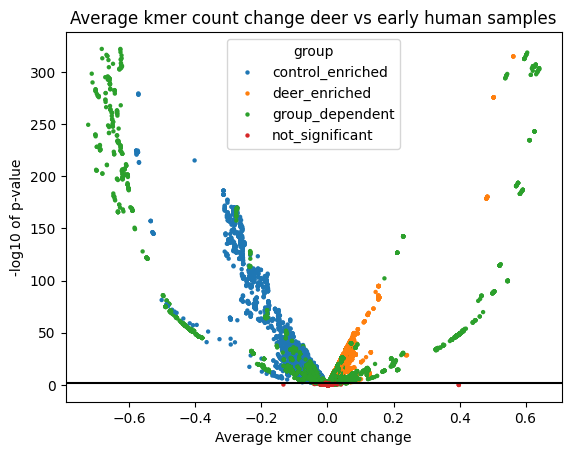

In [13]:
fig, ax = plt.subplots()
plt.axhline(y=-np.log10(0.01), color = 'black')
ax.autoscale()
ax.set_title('Average kmer count change deer vs early human samples')
ax.set_xlabel('Average kmer count change')
ax.set_ylabel('-log10 of p-value')
sns.scatterplot(data=common_kmer_matrix, x='deer-humearly_err', y = '-log10_deer-humearly_p-value', s=10, linewidth = 0, hue='group')
plt.savefig("../output/deer/volcano1.svg", dpi = 600, format = "svg")

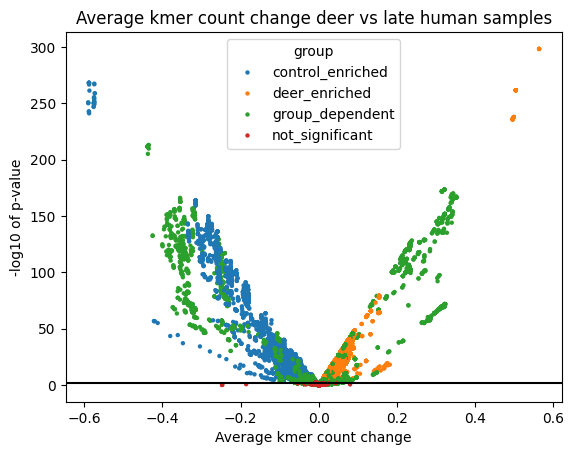

In [14]:
fig, ax = plt.subplots()
plt.axhline(y=-np.log10(0.01), color = 'black')
ax.autoscale()
ax.set_title('Average kmer count change deer vs late human samples')
ax.set_xlabel('Average kmer count change')
ax.set_ylabel('-log10 of p-value')
sns.scatterplot(data=common_kmer_matrix, x='deer-humlate_err', y = '-log10_deer-humlate_p-value', s=10, linewidth = 0, hue='group')
plt.savefig("../output/deer/volcano2.svg", dpi = 600, format = "svg")

6. Optionally re-examin rare k-mers similar to over-represented k-mers. Run the two cells below only if you want to include potential rare, but still enriched k-mers in the analysis.

7. Find enriched k-mers by applying the RMSE filter. Export enriched k-mers for use in host classification.

In [18]:
# Take the over-represented k-mers that pass the RMSE filter. This generates of enriched k-mers identified by PORT-EK.

# Uncomment this block if you didn't re-examine the rare k-mers.
enriched_kmer_matrix = common_kmer_matrix.loc[
    (common_kmer_matrix["group"] != "not_significant")
    & (common_kmer_matrix["group"] != "group_dependant")
    & (common_kmer_matrix["RMSE"] > min_RMSE)
]

# Comment this block if you didn't re-examine the rare k-mers.
# M_enriched = M_overrep_all[M_overrep_all['RMSE']>min_RMSE]
# nonM_enriched = nonM_overrep_all[nonM_overrep_all['RMSE']>min_RMSE]

# del all_kmer_matrix
enriched_kmer_stat_matrix = enriched_kmer_matrix.drop(sample_list, axis=1)
enriched_kmers = {
    group: list(
        enriched_kmer_stat_matrix[
            enriched_kmer_stat_matrix["group"] == f"{group}_enriched"
        ].index
    )
    for group in [GROUP_OF_INTEREST, "control"]
}
print([(group, len(value)) for group, value in enriched_kmers.items()])


def assign_host_numerical(sample_id):
    if sample_id in group_sample_idx["deer"]:
        host = 1
    else:
        host = 0
    return host


# Prepare and save count matrix with host labels for use by classifiers that predict the most probalbe host of a viral sequence.
counts_for_classifier = enriched_kmer_matrix[
    enriched_kmer_matrix["group"] == f"{GROUP_OF_INTEREST}_enriched"
].T
counts_for_classifier.drop(
    enriched_kmer_stat_matrix.columns.difference(["group", "exclusivity"]),
    axis=0,
    inplace=True,
)
counts_for_classifier["host"] = counts_for_classifier.index.map(assign_host_numerical)

counts_for_classifier.to_csv(f"../output/deer/{k}mer_counts_for_classifier.csv")
enriched_kmer_matrix.to_csv(f"../output/deer/enriched_{k}mer_count_matrix.csv")
enriched_kmer_stat_matrix.to_csv(f"../output/deer/enriched_{k}mer_stat_matrix.csv")
del counts_for_classifier

[('deer', 146), ('control', 1324)]


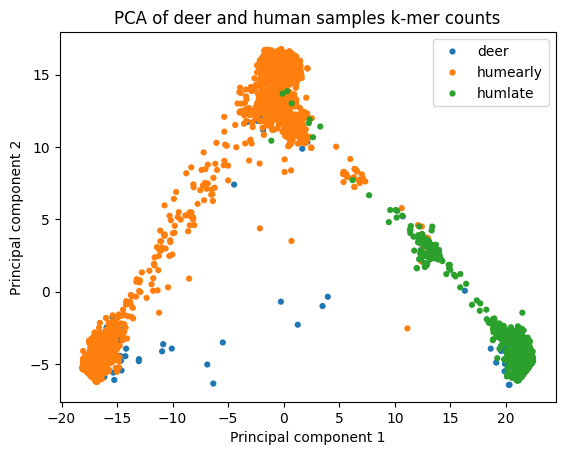

In [19]:
#Perform and plot PCA 
y_names = [name.split("_")[0] for name in sample_list]

pca = PCA(2)
X_pca = pd.DataFrame(pca.fit_transform(enriched_kmer_matrix[sample_list].T), index=sample_list)
fig, ax = plt.subplots()
ax.set_title('PCA of deer and human samples k-mer counts')
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
sns.scatterplot(x=X_pca[0], y=X_pca[1], hue=y_names, s=20, linewidth = 0)

#Uncomment the following line to save the plot as svg.
plt.savefig("../output/deer/PCA.svg", dpi = 600, format = "svg", bbox_inches='tight')

8. Map enriched k-mers to the reference genome and identify host-enriched mutations.

In [12]:
mm = 4

mutations = {}
n_pos = []
ref_pos = []
matches = []

for kmer in enriched_kmer_matrix.index:
    
    alns = aligner.align(ref_seq, kmer)
    temp_n = 0
    temp_m = []
    temp_ref_pos = []

    for aln in alns:
            aln_length = len(aln.indices[1])
            adj_score = aln.score + ((k-aln_length)*-2)

            if adj_score>=k-3*mm:
                temp_n += 1
                temp_m.append(aln.counts()[1])
                temp_ref_pos.append((aln.indices[0][0]+1,aln.indices[0][-1]+1))
                if aln_length>=k:
                    for i in range(aln_length):
                        ref_nuc = aln[0][i]
                        kmer_nuc = aln[1][i]
                        if ref_nuc == "-":
                            mut_pos = aln.indices[0][i-1]+1
                        else:
                            mut_pos = aln.indices[0][i]+1
                        if ref_nuc != kmer_nuc:
                            mutation = f"{ref_nuc}{mut_pos}{kmer_nuc}"
                            if mutation in mutations.keys():
                                mutations[mutation][kmer] = enriched_kmer_matrix.loc[kmer, "group"]
                            else:
                                mutations[mutation] = {kmer:enriched_kmer_matrix.loc[kmer, "group"]}
                else:
                    for i in range(k):
                        mut_pos_0 = aln.indices[0][0]-aln.indices[1][0]+i
                        try:
                            ref_nuc = ref_seq[mut_pos_0]
                        except:
                            continue
                        kmer_nuc = kmer[i]
                        mut_pos = mut_pos_0+1
                        if ref_nuc != kmer_nuc:
                            mutation = f"{ref_nuc}{mut_pos}{kmer_nuc}"
                            if mutation in mutations.keys():
                                mutations[mutation][kmer] = enriched_kmer_matrix.loc[kmer, "group"]
                            else:
                                mutations[mutation] = {kmer:enriched_kmer_matrix.loc[kmer, "group"]}
    n_pos.append(temp_n)
    matches.append(temp_m)
    ref_pos.append(temp_ref_pos)

enriched_kmer_matrix["n_pos"] = n_pos
enriched_kmer_matrix["ref_pos"] = ref_pos
enriched_kmer_matrix["matches"] = matches
enriched_kmer_matrix["genes"] = enriched_kmer_matrix["ref_pos"].apply(assign_gene_from_interval, args=[SARS_COV_2_GENES])
enriched_kmer_stat_matrix = enriched_kmer_matrix.drop(sample_list, axis=1)

mutations = {mut:kmers for mut, kmers in mutations.items() if len(kmers) > k//2 and len(set(kmers.values())) == 1}

In [13]:
mutations_id = list(mutations.keys())
mutations_ref_nuc = [mutid[0] for mutid in mutations_id]
mutations_mut_nuc = [mutid[-1] for mutid in mutations_id]
mutations_ref_pos = [int(mutid[1:-1]) for mutid in mutations_id]
mutations_groups = [list(mutations[mutid].values())[0] for mutid in mutations_id]
mutations_kmres = [list(mutations[mutid].keys()) for mutid in mutations_id]
mut_df = pd.DataFrame({"ref_nuc":mutations_ref_nuc, "ref_pos":mutations_ref_pos, "mut_nuc":mutations_mut_nuc, "group":mutations_groups,"kmers":mutations_kmres}, index=mutations_id).sort_values("ref_pos")
for group in SAMPLE_GROUPS:
    mut_df[f"{group}_agg_freq"] = mut_df["kmers"].apply(portek.calc_agg_freq, args=(group_sample_idx[group], enriched_kmer_matrix))
mut_df["genes"] = mut_df["ref_pos"].apply(lambda pos: assign_gene_from_position(pos, SARS_COV_2_GENES))
mut_df.to_csv(f"../output/bat/enriched_mutations.csv")

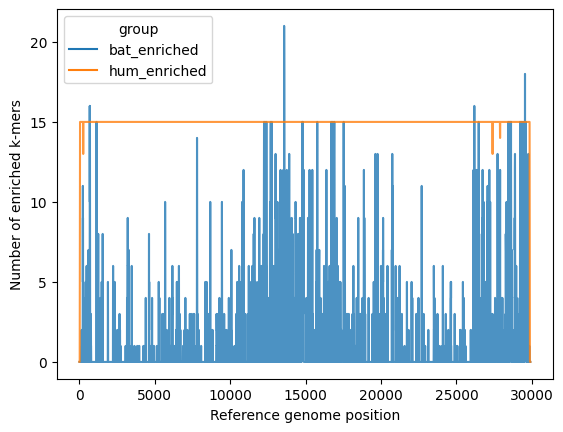

In [14]:
kmer_coverage = pd.DataFrame(0, index=pd.RangeIndex(1,len(ref_seq)), columns=["bat_enriched", "hum_enriched"])

for kmer in enriched_kmer_matrix.index:
    group = enriched_kmer_matrix.loc[kmer, "group"]
    for position in enriched_kmer_matrix.loc[kmer, "ref_pos"]:
        kmer_coverage.loc[position[0]:position[1], group] += 1

kmer_coverage_long = pd.melt(kmer_coverage, ignore_index=False, var_name="group")

fig, ax = plt.subplots()
sns.lineplot(data = kmer_coverage_long, x=kmer_coverage_long.index, y="value", hue="group")
ax.set_xlabel("Reference genome position")
ax.set_ylabel("Number of enriched k-mers")
for line in ax.lines:
    line.set_alpha(0.8)

plt.savefig(f"../output/bat/enriched_{k}mer_coverage.svg", format="svg", dpi=600)

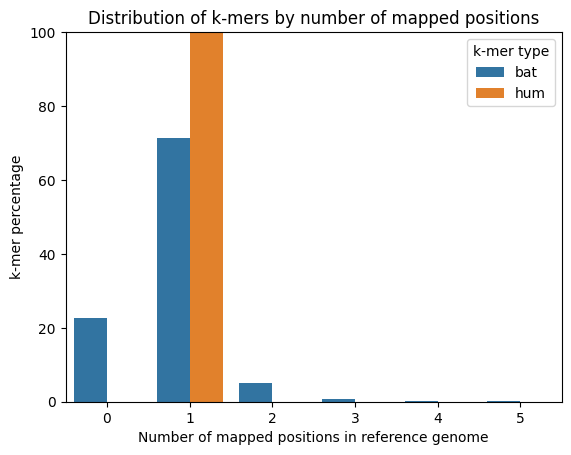

In [15]:
bat_dist = enriched_kmer_stat_matrix[enriched_kmer_stat_matrix["group"] == "bat_enriched"].value_counts("n_pos")/enriched_kmer_stat_matrix.value_counts('group')["bat_enriched"]*100
hum_dist = enriched_kmer_stat_matrix[enriched_kmer_stat_matrix["group"] == "hum_enriched"].value_counts("n_pos")/enriched_kmer_stat_matrix.value_counts('group')["hum_enriched"]*100
dist = pd.concat([bat_dist, hum_dist], axis=1, keys=["bat", "hum"]).fillna(0).sort_index()
dist_longform = dist.melt(ignore_index=False, var_name="k-mer type")
fig, ax = plt.subplots()
sns.barplot(data = dist_longform, x = dist_longform.index, y="value", hue="k-mer type")
ax.set_title("Distribution of k-mers by number of mapped positions")
ax.set_ylabel("k-mer percentage")
ax.set_xlabel("Number of mapped positions in reference genome")
ax.set_ylim(0,100)

plt.savefig(f"../output/bat/enriched_{k}mer_map_distr.svg", format="svg", dpi=600)

/tmp/ipykernel_3501800/923088246.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6387832699619772' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mut_coverage.loc[position, f"{group}_{mut_group}"] += mut_df.loc[mutation, f"{group}_agg_freq"]
/tmp/ipykernel_3501800/923088246.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0009610764055742432' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mut_coverage.loc[position, f"{group}_{mut_group}"] += mut_df.loc[mutation, f"{group}_agg_freq"]


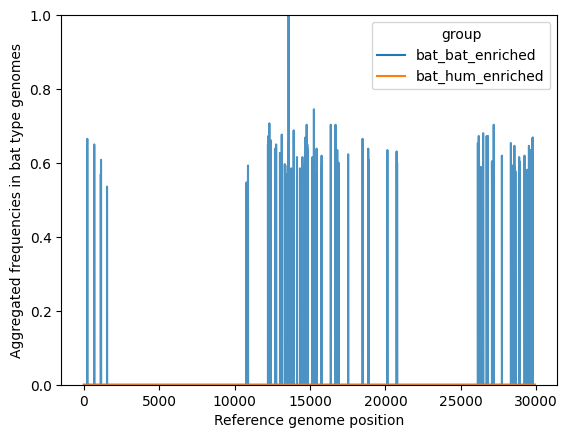

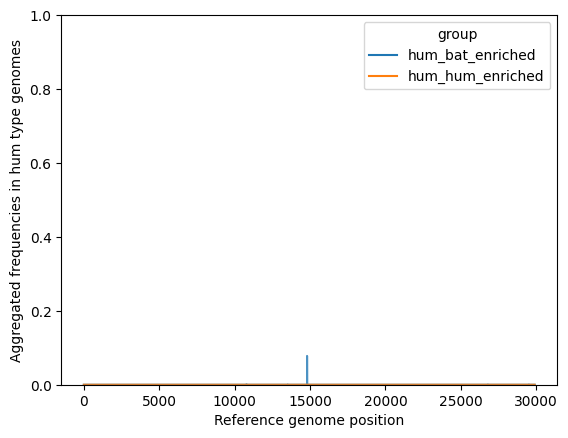

In [16]:
mut_coverage = pd.DataFrame(0, index=pd.RangeIndex(1,len(ref_seq)), columns=["bat_bat_enriched", "bat_hum_enriched", "hum_bat_enriched","hum_hum_enriched"])
for group in SAMPLE_GROUPS:
    for mutation in mut_df.index:
        mut_group = mut_df.loc[mutation, "group"]
        position = mut_df.loc[mutation, "ref_pos"]
        mut_coverage.loc[position, f"{group}_{mut_group}"] += mut_df.loc[mutation, f"{group}_agg_freq"]

bat_mut_coverage_long = pd.melt(mut_coverage.iloc[:,:2], ignore_index=False, var_name="group")

fig, ax = plt.subplots()
sns.lineplot(data = bat_mut_coverage_long, x=bat_mut_coverage_long.index, y="value", hue="group")
ax.set_xlabel("Reference genome position")
ax.set_ylabel("Aggregated frequencies in bat type genomes")
ax.set_ylim(0,1)
for line in ax.lines:
    line.set_alpha(0.8)

plt.savefig(f"../output/bat/mutaions_in_bat.svg", format="svg", dpi=600)

hum_mut_coverage_long = pd.melt(mut_coverage.iloc[:,2:], ignore_index=False, var_name="group")

fig, ax = plt.subplots()
sns.lineplot(data = hum_mut_coverage_long, x=hum_mut_coverage_long.index, y="value", hue="group")
ax.set_xlabel("Reference genome position")
ax.set_ylabel("Aggregated frequencies in hum type genomes")
ax.set_ylim(0,1)
for line in ax.lines:
    line.set_alpha(0.8)

plt.savefig(f"../output/bat/mutaions_in_hum.svg", format="svg", dpi=600)

In [19]:
enriched_kmer_stat_matrix["n_pos"].value_counts()

n_pos
1    31763
0      619
2      146
3       22
4        9
5        3
Name: count, dtype: int64